# Assignment 3: Adversarial Samples

We want to show that deep neural networks are susceptible to adversarial attacks.
For this reason, we take a network, pre-trained on the ImageNet dataset, and a correctly classified test sample $\mathcal X$ such that $\argmax_o y_o = \tau$.
We generate an adversarial sample $\check{\mathcal X}$ using a gradient normalization technique, and assure that the output of the network has changed: $\argmax_o \check y_o \neq \tau$.
Expecting pixel values of the original image $\mathcal X$ in range [0,1], the  adversarial sample $\check{\mathcal X}$ can be generated via gradient ascent:

$$\check{\mathcal X} = \mathcal X + \alpha \frac{\nabla_{\mathcal X} \mathcal J}{\|\nabla_{\mathcal X} \mathcal J\|}$$

where

$$\mathcal J = -\ln y_\tau$$
   
represents the loss for the correct class $\tau$ of the sample.

## Test Sample

We provide the source code to download the test sample from our server.
Please run the cell below to obtain the test image.
This test sample is from the original class `Banana` with index $\tau=954$.

In [8]:
filename = "TestImage-Bananas.jpg"

# download the file from our seafile server
import os
if not os.path.exists(filename):
    url = f"https://seafile.ifi.uzh.ch/d/fcbca8aa552540e98997/files/?p=%2F{filename}&dl=1"
    import urllib.request
    urllib.request.urlretrieve(url, filename)
    print ("Downloaded datafile", filename)

# open the image using PIL (the default image processing library in PyTorch)
import PIL.Image
pil_image = PIL.Image.open(filename)

## Pre-trained Network

We want to attack a ResNet-18 network that is pre-trained on the ImageNet dataset.

### Task (a): Download and Instantiate Pre-Trained Network (2 Points)

Implement PyTorch source code to download a ResNet-18 network that is pre-trained on the ILSVRC 2012 dataset.
You can make use of functionality provided in `torchvision.models`, which you can find here: https://pytorch.org/vision/0.11/models.html

Note:

* The ResNet-18 network includes a batch normalization layer, so you need to take caution that the network can be used to process test images.

In [19]:
import torch
import torchvision
from torchvision import transforms

# download a pre-trained ResNet-18 module from torchvision
network = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
# anything else?
for param in network.parameters():
    param.requires_grad = False
network.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Image Preprocessing

To work with a network pre-trained on the ImageNet dataset (more specifically, the ILSVRC2012 training set), several image processing steps have to be performed when classifying the image.
The PyTorch documentation states four steps:

1. Scaling the image such that the shorter size is 256 pixels.
2. Taking a center crop of the image in size $224\times224$.
3. Converting the image to type `torch.tensor` and dividing pixel values by 255.
4. Normalizing pixel values with `mean=[0.485, 0.456, 0.406]` and `std=[0.229, 0.224, 0.225]`.

### Task (b): PyTorch Transforms (4 Points)

Implement a series of PyTorch transforms that apply the different preprocessing steps defined above. 
Split the transforms such that the first part generates pixel values in the range that the adversarial image generation technique expects, and the remaining steps into the second part. 
Apply the first part to the original image.

In [20]:
# Implement the first part of the transforms
transform_1 = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

# Implement the second part of the transforms
transform_2 = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# apply the first part of the transform to the original image
X = transform_1(pil_image)

## Network Prediction

In order to obtain the classifier output of the network, we need to process the image through the network, and compute the predicted class.

### Task (c): Class Prediction Function (4 Points)

Implement a function the takes an image, applies the second part of the transform to the input, and forwards this through the network. 
Compute and return the predicted class and the probability of the predicted class. 
Remember that the network is designed to process batches.

In [21]:
def predict(sample):
    # the input has gone through the first part of the transforms, we need to apply the second part
    sample = transform_2(sample)
    # forward the result through the network
    output = network(sample)
    # print(output.shape)
    ori_class = torch.argmax(output, dim=1)
    # compute the class probabilities
    probs = torch.softmax(output, dim=1)
    # print(probs.shape)
    # return the predicted class and its probability
    return ori_class, probs[:, ori_class]

### Task (d): Obtain Gradient for Original Sample (4 Points)

Call the function from (c) with the original image `X`. 
Compute the loss $\mathcal J$, by assuming that the original sample is correctly classified. 
Obtain the gradient of the loss with respect to the input image $\nabla_{\mathcal X} \mathcal J$. 

Note:
 * In order to obtain the gradient required for the adversarial generation, you need to request the automatic differentiation system of PyTorch to provide this gradient.

In [23]:
# request autograd to compute the gradient of the loss with respect to X
X.requires_grad_(True)

# compute the class of the original sample and its probability
original_class, original_prob = predict(X.unsqueeze(0))
# print(original_class, original_prob)

# compute the loss
J = -torch.log(original_prob)

# compute the partial derivative of the loss with respect to the input
J.backward()
gradient = X.grad

### Test 1: Correct Classification

Here, we assure that the test sample is correctly classified by the network (which should be the case).
If it is not, you might need to check your implementation above.
We also test that the gradient was computed.

In [24]:
# check that the class is correct
assert original_class == 954
assert original_prob > 0.9

# also check that the gradient was computed
assert X.grad is not None

## Adversarial Sample

We want to make use of the gradient computed in the cell above to create an adversarial sample $\check{\mathcal X}$, according to the definition above.

### Task (e): Adversarial Sample (3 Points)

Create the adversarial sample $\check{\mathcal X}$ using a value of $\alpha=0.5$. 
Remember that you need to detach from the gradient in order to perform this operation. 
Forward the adversarial sample through the network and predict its class using the function from (c).

In [26]:
# compute adversarial sample
gradient = gradient.detach()
X_check = torch.clip((X + 0.5 * gradient / gradient.abs().max()), 0., 1.)
# predict class for adversarial sample
adversarial_class, adversarial_prob = predict(X_check.unsqueeze(0))

### Test 2: Wrong Classification

Below, we test that the adversarial sample is no longer classified correctly.
It is possible that you need to increase the value of $\alpha$ in order to change the prediction for the adversarial sample.

In [27]:
assert adversarial_class != 954

### Visualization 1: Original and Adversarial Prediction

The cell below provides a visualization of the original and the adversarial sample.
It also plots the predicted class and its probability.

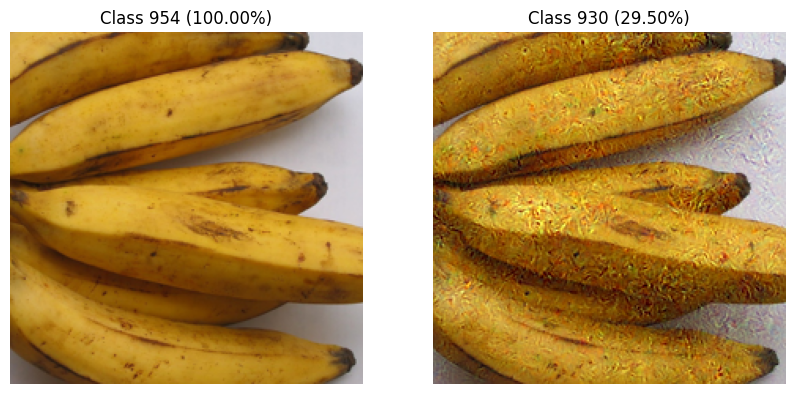

In [28]:
from matplotlib import pyplot
# create two sub-plots
fig,axs = pyplot.subplots(1,2, figsize=(10,5))

# show original image and its prediction
axs[0].imshow(X.detach().permute(1,2,0))
axs[0].axis("off")
axs[0].set_title(f"Class {original_class.item()} ({original_prob.item()*100:2.2f}%)")
# show adversarial image and its prediction
axs[1].imshow(torch.clamp(X_check.detach().permute(1,2,0), 0, 1))
axs[1].axis("off")
axs[1].set_title(f"Class {adversarial_class.item()} ({adversarial_prob.item()*100:2.2f}%)")

pyplot.savefig("A3_samples.pdf")